from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from scipy import sparse


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout,SpatialDropout1D,TextVectorization,GRU

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-19 23:59:41.545989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 23:59:41.934152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 23:59:42.622122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("reviews_dataset.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df = df[["Text","Score"]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [6]:
df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [7]:
def change_value_range(score):
  return score - 1

In [8]:
df["Score"] = df["Score"].apply(change_value_range)

In [9]:
df["Score"].value_counts()

Score
4    363122
3     80655
0     52268
2     42640
1     29769
Name: count, dtype: int64

In [10]:
df.isna().sum()

Text     0
Score    0
dtype: int64

In [11]:
len(df)

568454

In [12]:
df["Score"].value_counts().sort_index().values

array([ 52268,  29769,  42640,  80655, 363122])

In [13]:
scores = df["Score"].value_counts().sort_index().index
values = df["Score"].value_counts().sort_index().values

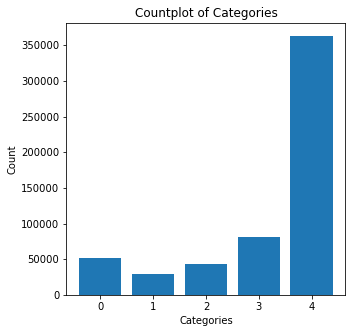

In [14]:
plt.figure(figsize=(5,5))
plt.bar(scores,values)
plt.title("Countplot of Categories")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.show()

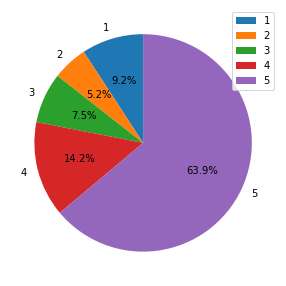

In [15]:
plt.figure(figsize=(5,5))
plt.pie(df["Score"].value_counts().sort_index(),labels=[1,2,3,4,5],startangle=90,autopct="%1.1f%%")
plt.legend()
plt.show()

In [16]:
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /home/samarth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samarth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
lm = WordNetLemmatizer()
stop_words = stopwords.words("english")
def text_preprocessing(l):
    text = re.sub("[^a-zA-Z]", ' ',str(l))
    text = text.lower()
    text = text.split()
    text = [lm.lemmatize(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

In [18]:
import dask.dataframe as dd

In [20]:
ddf = dd.from_pandas(df, npartitions=8)  


ddf['processed_text'] = ddf['Text'].apply(text_preprocessing, meta=('processed_text', 'str'))


df_processed = ddf.compute()

In [ ]:
df_processed.head()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_processed["processed_text"].values,df_processed["Score"].values,test_size=0.2,random_state=42)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model = Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((1, -1)))
model.add(LSTM(100,input_dim=(50), return_sequences=True,activation="tanh"))  
model.add(LSTM(100, return_sequences=True,activation="tanh"))  
model.add(GRU(100,activation="tanh"))
model.add(Dense(5, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset.shuffle(10000).batch(512),
                    epochs=20,
                    verbose=1)

In [ ]:
loss,acc = model.evaluate(test_dataset.shuffle(10000).batch(512))

In [ ]:
model.save("reviews_model_77.keras")